In [1]:
from pathlib import Path

PROJECT_ROOT_DIR = str(Path.cwd().parent)
PROJECT_ROOT_DIR

'/root/llm_graph_embedder'

# Load evaluation data

In [2]:
import pandas as pd

test_data = pd.read_parquet(f"{PROJECT_ROOT_DIR}/dataset/test.parquet").sample(n=4000)

In [3]:
def format_test_conversations(sample):
    prompt_template = """<human>: {human_turn}\n\n<gpt>:"""

    return prompt_template.format(
        human_turn=sample["formatted_conversations"][0]["value"],
        gpt_turn=sample["formatted_conversations"][1]["value"],
    )

In [4]:
test_data["full_conversation"] = test_data.apply(format_test_conversations, axis=1)

In [5]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict(
    {
        "test": Dataset.from_pandas(
            test_data[["full_conversation"]].reset_index(drop=True)
        ),
    }
)

In [6]:
dataset

DatasetDict({
    test: Dataset({
        features: ['full_conversation'],
        num_rows: 4000
    })
})

# Load model with LoRA configuration

## Loading Gemma 2 2B-it as `AutoModel`

In [7]:
import torch
from transformers import AutoTokenizer, AutoModel

model_path = f"{PROJECT_ROOT_DIR}/model/graph_embedder"

tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    local_files_only=True,
)

model = AutoModel.from_pretrained(
    model_path,
    local_files_only=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading adapter weights from /root/llm_graph_embedder/model/graph_embedder led to unexpected keys not found in the model: model.layers.0.mlp.down_proj.lora_A.default.weight, model.layers.0.mlp.down_proj.lora_B.default.weight, model.layers.0.mlp.gate_proj.lora_A.default.weight, model.layers.0.mlp.gate_proj.lora_B.default.weight, model.layers.0.mlp.up_proj.lora_A.default.weight, model.layers.0.mlp.up_proj.lora_B.default.weight, model.layers.0.self_attn.k_proj.lora_A.default.weight, model.layers.0.self_attn.k_proj.lora_B.default.weight, model.layers.0.self_attn.o_proj.lora_A.default.weight, model.layers.0.self_attn.o_proj.lora_B.default.weight, model.layers.0.self_attn.q_proj.lora_A.default.weight, model.layers.0.self_attn.q_proj.lora_B.default.weight, model.layers.0.self_attn.v_proj.lora_A.default.weight, model.layers.0.self_attn.v_proj.lora_B.default.weight, model.layers.1.mlp.down_proj.lora_A.default.weight, model.layers.1.mlp.down_proj.lora_B.default.weight, model.layers.1.mlp.gate_pr

In [8]:
model.eval()

Gemma2Model(
  (embed_tokens): Embedding(256000, 2304, padding_idx=0)
  (layers): ModuleList(
    (0-25): 26 x Gemma2DecoderLayer(
      (self_attn): Gemma2Attention(
        (q_proj): lora.Linear(
          (base_layer): Linear(in_features=2304, out_features=2048, bias=False)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict(
            (default): Linear(in_features=2304, out_features=8, bias=False)
          )
          (lora_B): ModuleDict(
            (default): Linear(in_features=8, out_features=2048, bias=False)
          )
          (lora_embedding_A): ParameterDict()
          (lora_embedding_B): ParameterDict()
          (lora_magnitude_vector): ModuleDict()
        )
        (k_proj): lora.Linear(
          (base_layer): Linear(in_features=2304, out_features=1024, bias=False)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict(
            (default)

In [9]:
model.to("cuda")

Gemma2Model(
  (embed_tokens): Embedding(256000, 2304, padding_idx=0)
  (layers): ModuleList(
    (0-25): 26 x Gemma2DecoderLayer(
      (self_attn): Gemma2Attention(
        (q_proj): lora.Linear(
          (base_layer): Linear(in_features=2304, out_features=2048, bias=False)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict(
            (default): Linear(in_features=2304, out_features=8, bias=False)
          )
          (lora_B): ModuleDict(
            (default): Linear(in_features=8, out_features=2048, bias=False)
          )
          (lora_embedding_A): ParameterDict()
          (lora_embedding_B): ParameterDict()
          (lora_magnitude_vector): ModuleDict()
        )
        (k_proj): lora.Linear(
          (base_layer): Linear(in_features=2304, out_features=1024, bias=False)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict(
            (default)

# Generating embeddings

In [27]:
curr = 0

def generate_embeddings(sample):
    global curr
    curr += 1
    print(f"Processed {curr} samples")

    # Tokenize the input sentences
    inputs = tokenizer(
        sample,
        padding=True,
        truncation=True,
        max_length=100,
        return_tensors="pt"
    )
    
    # Move inputs to GPU if available
    device = torch.device("cuda")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.last_hidden_state
        # Pooling: Mean pooling over the sequence length
        embeddings = hidden_states.mean(dim=1)
    
    # Convert embeddings to CPU and numpy for storage
    return embeddings.cpu().numpy()

In [28]:
%%time

test_data["embeddings"] = test_data[["full_conversation"]].map(generate_embeddings)

Processed 1 samples
Processed 2 samples
Processed 3 samples
Processed 4 samples
Processed 5 samples
Processed 6 samples
Processed 7 samples
Processed 8 samples
Processed 9 samples
Processed 10 samples
Processed 11 samples
Processed 12 samples
Processed 13 samples
Processed 14 samples
Processed 15 samples
Processed 16 samples
Processed 17 samples
Processed 18 samples
Processed 19 samples
Processed 20 samples
Processed 21 samples
Processed 22 samples
Processed 23 samples
Processed 24 samples
Processed 25 samples
Processed 26 samples
Processed 27 samples
Processed 28 samples
Processed 29 samples
Processed 30 samples
Processed 31 samples
Processed 32 samples
Processed 33 samples
Processed 34 samples
Processed 35 samples
Processed 36 samples
Processed 37 samples
Processed 38 samples
Processed 39 samples
Processed 40 samples
Processed 41 samples
Processed 42 samples
Processed 43 samples
Processed 44 samples
Processed 45 samples
Processed 46 samples
Processed 47 samples
Processed 48 samples
P

In [29]:
test_data

,paper_id,title,abstract,publishing_year,label,id,graph,conversations,node_idx,formatted_conversations,full_conversation,embeddings
node_idx,,,,,,,,,,,,
41774,2912381129,exploiting noma oma for multi uav communicatio...,This paper advocates a pair of strategies in n...,2019,28,arxiv_test_41774,"{'edge_index': [[1, 2, 0, 3, 4, 5, 6, 7, 8, 9,...","[{'from': 'human', 'value': 'Given a citation ...",41774,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.9760091, 0.028717011, -0.17444798, -0.9360..."
100364,2967718185,matrix lie maps and neural networks for solvin...,The coincidence between polynomial neural netw...,2019,13,arxiv_test_100364,"{'edge_index': [[1, 2, 0, 3, 4, 5, 6, 7, 8, 9,...","[{'from': 'human', 'value': 'Given a citation ...",100364,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.6520381, 0.42188114, -0.06443102, -0.77734..."
149026,2918175094,span based open information extraction,"In this paper, we propose a span based model c...",2019,30,arxiv_test_149026,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",149026,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.47073057, 0.044805866, 0.053309336, -0.765..."
33818,2943838036,kindling the darkness a practical low light im...,Images captured under low-light conditions oft...,2019,16,arxiv_test_33818,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",33818,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[1.1125497, 0.0033647537, -0.1683146, -0.8137..."
85955,3003293501,automatic weak imposition of free slip boundar...,Imposition of free slip boundary conditions in...,2020,7,arxiv_test_85955,"{'edge_index': [[1, 2, 3, 4, 5, 0, 6, 7, 8, 9,...","[{'from': 'human', 'value': 'Given a citation ...",85955,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[1.1096002, 0.08398815, -0.14018351, -0.93002..."
...,...,...,...,...,...,...,...,...,...,...,...,...
110926,2958440724,the tradeoff between privacy and accuracy in a...,Privacy has raised considerable concerns recen...,2019,24,arxiv_test_110926,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",110926,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[1.1746846, 0.0006369018, -0.17864317, -0.793..."
67438,2953465900,elkppnet an edge aware neural network with lar...,Semantic segmentation has been a hot topic acr...,2019,16,arxiv_test_67438,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",67438,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[1.1123475, 0.06709691, -0.17441507, -0.88456..."
15833,3007809936,communication efficient weighted reservoir sam...,We consider communication-efficient weighted a...,2020,34,arxiv_test_15833,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 0, 8, 4,...","[{'from': 'human', 'value': 'Given a citation ...",15833,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[1.128495, 0.08006733, -0.16481628, -0.958671..."


# Visualizing embeddings

In [30]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_embeddings(x_vals, y_vals, labels):
    random.seed(0)

    # Generate 40 distinct colors using a custom colormap
    cmap = ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20)).tolist() * 2)  # Extends tab20 to 40 colors

    plt.figure(figsize=(12, 12))

    scatter = plt.scatter(
        x_vals,
        y_vals,
        c=labels,
        cmap=cmap,  # Custom colormap with 40 colors
        s=10,       # Adjust size of points
        alpha=0.8   # Transparency
    )

    # Add a colorbar to show the mapping of colors to classes
    cbar = plt.colorbar(scatter, ticks=np.arange(0, 40, step=1))
    cbar.set_label("Classes")
    plt.title("2D Embedding Visualization with Class Colors")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

In [31]:
from umap.umap_ import UMAP


def reduce_dimensions(values):
    vectors = np.asarray(values)

    reducer = UMAP()
    reducer.fit(vectors)
    vectors = reducer.transform(vectors)
    

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals

In [32]:
%%time

x_coord, y_coord = reduce_dimensions(
    np.vstack(test_data["embeddings"].values)
)

/root/llm_graph_embedder/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 26.7 s, sys: 2min 23s, total: 2min 49s
Wall time: 2min 33s


/root/llm_graph_embedder/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


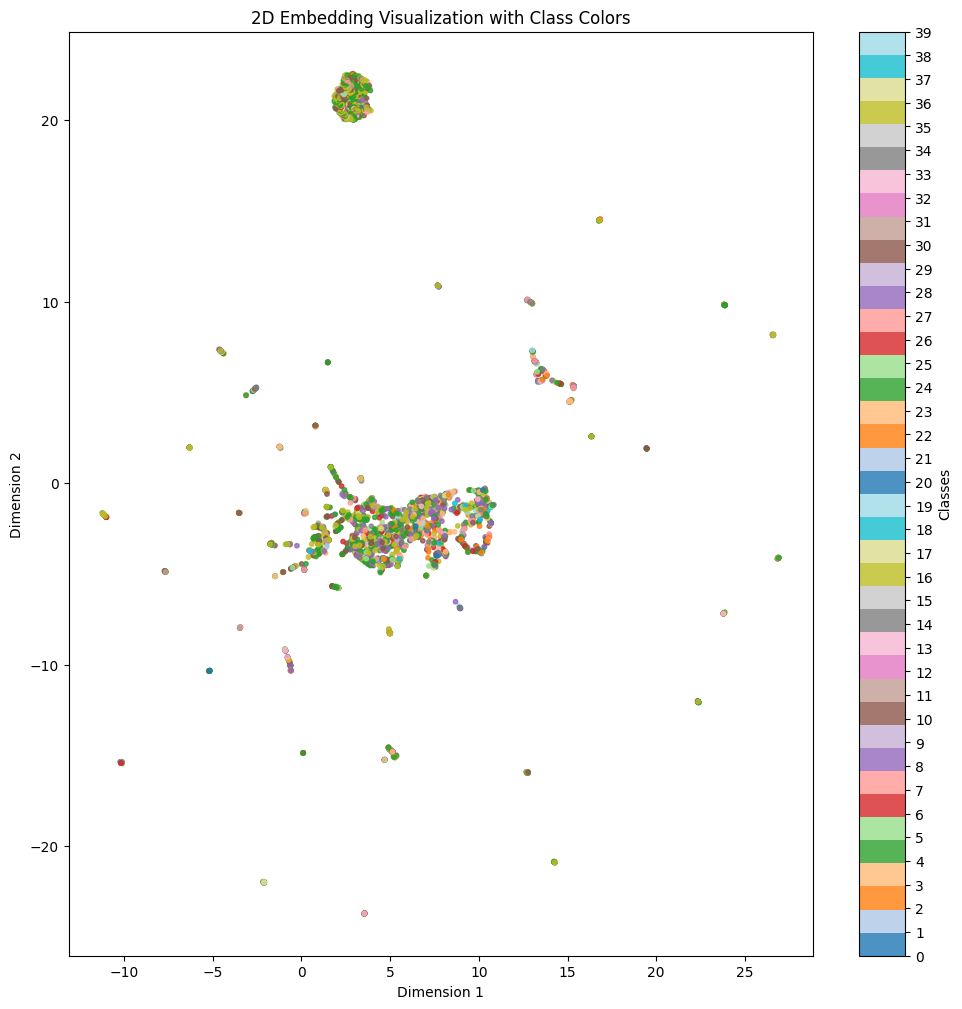

In [33]:
plot_embeddings(x_coord, y_coord, test_data["label"].values)